In [14]:
!pip install pandas_datareader

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web

import numpy as np

import datetime

from scipy import stats as sts
from statsmodels.formula import api as sm
import scipy.optimize as opt
from scipy.optimize import broyden1, minimize

from functools import partial
from functools import reduce

import pickle

# Lucas Tree {-}

In [25]:
#CLEANING

START = datetime.datetime(1970,10,1)
END = datetime.datetime(2018,7,1)
RPCE = web.DataReader("PCECC96","fred",START,END)
W5000 = web.DataReader("WILL5000INDFC","fred",START,END)
GDPDEF = web.DataReader("GDPDEF","fred",START,END)
TBILL = web.DataReader("TB3MS","fred",START,END)
TBILL = TBILL.fillna(method="ffill")
W5000 = W5000.fillna(method="ffill")
TBILL = TBILL.resample("QS").first()
W5000 = W5000.resample("QS").first()
df = pd.DataFrame(columns=["RPCE","W5000","TBILL","GDPDEF"], index=RPCE.index)
df["RPCE"] = RPCE
df["W5000"] = W5000
df["TBILL"] = (TBILL/100) + 1
df["GDPDEF"] = (GDPDEF/100)
df["GDPDEF"] /= df["GDPDEF"][0]
df["real_W5000"] = df["W5000"]/(df["GDPDEF"])
df["R"] = df["real_W5000"]/df["real_W5000"].shift(1)
df.dropna(axis = 0, inplace = True)

In [26]:
def p1_0():
    df["R"].plot()
    plt.show()

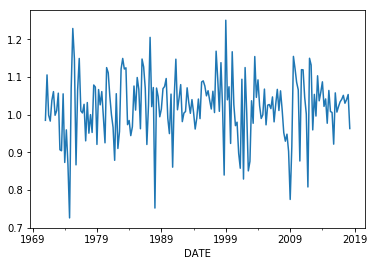

In [27]:
p1_0()

In [36]:
def def_params():
    β = 1-1e-2

In [45]:
def p1_1_2(γ,df,β):
    
    β = def_params()
    
    r=df["RPCE"]
    
    return β*((r**(-γ)).shift(-1)/(r**(-γ)))

In [46]:
def p1_1_3(γ,*args):
    
    β = def_params()
    df,β = args
    
    r = df["R"]
    m = p1_1_2(γ,df,β)
    
    return 1-m.cov(r)-m.mean()*r.mean()

In [47]:
def p1_1_4():
    
    β = def_params()
    
    s = opt.root(p1_1_3, 1., args=(df,β))
    
    γ_s = s.x[0]
    
    print(γ_s)

In [55]:
def p1_2():
    print("""
    
To determine if the parameter is reasonable, 
I would check other data sources and assess 
the reliability of the sample, and perhaps try to
resample with another data set and try again.
    
    """)

In [80]:
p1_2()


    
To determine if the parameter is reasonable, 
I would check other data sources and assess 
the reliability of the sample, and perhaps try to
resample with another data set and try again.
    
    


In [81]:
def p1_3_1(γ,*args):
    
    df, β = args
    
    t = df["TBILL"]
    
    m = p1_1_2(γ,df,β).mean()
    
    e = t-(1/m)
    
    return np.sum(e**2)

In [82]:
def p1_3_2():
    
    s = opt.root(p1_3_1,1.0,args=(df,β))
    
    γ_s = s.x[0]
    
    print(γ_s)

In [83]:
def p1_4_1(β,γ,df):
    
    r = df["R"]
    
    m = p1_1_2(γ,df,β)
    
    e_1 = 1-m.cov(r)-m.mean()*r.mean()
    
    t = df["TBILL"]
    
    e_t = t.mean()
    
    e_2 = np.sum((t-(1/e_t))**2)
    
    return np.array([e_1, e_2])

In [84]:
def p1_4_2(params,df):
    
    β,γ = params
    
    return np.sum(p1_4_1(β,γ,df)**2)

In [85]:
def p1_4_3(): 
    
    init = np.array([1.,3.])
    
    s = opt.minimize(p1_4_2,init,args=df)
    
    β_s,γ_s = s.x
    
    print("γ* =",γ_s,"\nβ* =",β_s)
    
    β_grid = np.linspace(.95,1,100)
    γ_grid = np.linspace(1,10,100)
    BETA,GAMMA = np.meshgrid(β_grid,γ_grid)
    
    objectives = np.empty_like(BETA)
    
    for i in range(len(γ_grid)):
        for j in range(len(β_grid)):
            objectives[i,j] = p1_4_2([β_grid[j],γ_grid[i]],df)

    fig,ax = plt.subplots(1,2)
    
    ax[0].contour(GAMMA, BETA, objectives)
    ax[0].set_xlabel("γ")
    ax[0].set_ylabel("β")
    
    for i,β in enumerate(β_grid[::10]):
        ax[1].plot(γ_grid, objectives[10*(i-1)],label="β ="+str(β))
    
    axes[1].legend()
    
    axes[1].set_xlabel("γ")
    axes[1].set_ylabel("objective")
    
    plt.show()

# Kyle {-}

In [86]:
AAPL = pickle.load(open("AAPL","rb"))

C = pickle.load(open("C","rb"))

GBX = pickle.load(open("GBX","rb"))

SPY = pickle.load(open("SPY","rb"))

THO = pickle.load(open("THO","rb"))

In [93]:
class OrderBook(object):

    def __init__(self,data,window,name):
        
        # Thank you Bethany for this set up.
        
        self.data = data[1]
        self.timestamp = data[0]
        self.lower = window[0]
        self.upper = window[1]
        self.name = name
        
        df = pd.DataFrame.from_dict(self.data,orient="index")
    
        df.columns = ["Quantity","Type","NaN0","NaN1"]
        df = df[["Quantity","Type"]]
        
        self.demand = df[df["Type"]=="B"].sort_index(ascending=False)
        self.supply = df[df["Type"]=="S"].sort_index()
        
        self.demand["QD"] = -1*self.demand["Quantity"].cumsum()
        self.supply["QS"] = self.supply["Quantity"].cumsum()
        
        orders = pd.concat([self.demand,self.supply])
        orders = orders.fillna(0)
        orders["Q"] = orders["QD"]+orders["QS"]
        
        self.midpoint = orders[orders.Q<0].index.values[0]
        
        self.orders = orders[(orders.index>window[0]*self.midpoint) 
        and (orders.index<window[1]*self.midpoint)]
        
        self.Q = self.orders["Q"]
        
        self.P = self.orders.index.values
                
    def estimate(self):
        
        m,b,r,p,se = sts.linregress(self.P,self.Q)
        
        self.γ = b
        self.β = m
        
        self.price = -1*self.γ/self.β
        self.ratio = self.β    

    def plot(self):
        
        fig = plt.figure()
        
        plt.plot(self.demand.index.values,self.demand["QD"],
                 label="$D$")
        plt.plot(self.supply.index.values,self.supply["QS"],
                 label="$S$")
        
        p_grid = np.linspace(self.lower*self.midpoint, 
                             self.upper*self.midpoint)
        
        plt.plot(p_grid,self.γ+self.β*p_grid,
                 "k",label="estimate")
        
        plt.xlim(.5*self.midpoint,1.5*self.midpoint)
        
        plt.xlabel("$P$")
        plt.ylabel("$Q$")
        
        plt.title(str(self.name)+", t ="+str(self.timestamp))
        
        plt.legend()
        plt.show()
        
    def compare(self):
        
        print("•  "+str(self.name)+"price :"+str(self.price))
        
        print("•  "+str(self.name)+"midpoint :"+str(self.midpoint))
        
        
    def disp(self):
        
        self.estimate()
        
        self.plot()

In [88]:
def p2_1_2(ret=False):

    aapl = OrderBook(AAPL[0],(0.9,1.1),"AAPL")
    
    c = OrderBook(C[0],(0.9,1.1),"C")
    
    gbx = OrderBook(GBX[0],(0.9,1.1),"GBX")
    
    spy = OrderBook(SPY[0],(0.9,1.1),"SPY")
    
    tho = OrderBook(C[0],(0.9,1.1),"THO")
    
    if ret: return aapl,c,gbc,spy,tho
    
    aapl.disp()
    c.disp()
    gbx.disp()
    spy.disp()
    tho.disp()

In [89]:
def p2_2_1(df,name):
    
    r = np.zeros(len(df))
    
    for i in range(len(df)):
        
        lob = OrderBook(df[i],(0.9,1.1),name)
        
        lob.estimate()
        
        r[i] = lob.ratio
    
    fig = plt.figure()
    
    plt.plot(r)
    plt.title(name)
    
    plt.xlabel("$t$")
    plt.ylabel("estimate")
    
    plt.disp()

In [90]:
def p2_2_2():
    
    aapl,c,gbc,spy,tho = p2_1_2(ret=True)
    
    aapl,c,gbc,spy,tho = p2_1_2(ret=True)
    
    p2_2_1(aapl,"AAPL")
    p2_2_1(c,"C")
    p2_2_1(spy,"SPY")
    p2_2_1(gbx,"GBX")
    p2_2_1(tho,"THO")

In [91]:
def p2_3():
    
    aapl.compare()
    c.compare()
    gbx.compare()
    spy.compare()
    tho.compare()